In [22]:
import pandas as pd
import re
import itertools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import igraph as ig
from IPython.display import HTML
import multiprocessing
import pickle as pkl
import random
from collections import Counter
import os
import subprocess
from scipy.stats import mannwhitneyu
import ete3
from copy import deepcopy
from math import ceil
import openpyxl

%cd /nobackup1b/users/payette/eggNOGbyClass3

ncbi = ete3.NCBITaxa()

%run assess_connections-functions.ipynb

/nobackup1c/users/payette/eggNOGbyClass3


In [23]:
ABCDG_sampled_genomes = pd.read_excel('ABGD_tree_taxa.xlsx') #check this is latest version
ABCDG_sampled_genomes = ABCDG_sampled_genomes[ABCDG_sampled_genomes['TaxID'] != 2762020] #Exclude this taxa b/c error

In [24]:
lineages = pd.DataFrame()
for taxid in ABCDG_sampled_genomes['TaxID'].unique():
    if pd.isna(taxid):
        continue
    lineages = lineages.append({tax_rank: tmp_taxid 
                                 for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()},
                                ignore_index=True)
lineages = lineages.reindex(columns=['class', 'family',  'genus', 'phylum',
                                     'order', 'species', 'superkingdom']).copy()
lineages = lineages.query('superkingdom == 2').copy()

In [25]:
#one liner to make all Proteobacteria (1224) classes into phyla
lineages.loc[lineages['phylum']==1224, 'phylum'] = lineages.loc[lineages['phylum']==1224, 'class']

In [26]:
sampled_phyla = [phylum for phylum in lineages.phylum.unique().astype(int) if phylum > 0]

In [27]:
working_groups  = pd.read_parquet('working_eggNOG_groups.parquet')
working_trees   = pd.read_parquet( 'working_eggNOG_trees.parquet')
eggNOG_taxonomy = pd.read_parquet(      'eggNOG_taxonomy.parquet')

In [28]:
# Load previously run data from find_transfers code.
with open('ABGD_new_phyla_results.pkl', 'rb') as _:   # ABCDG_proteo_all_results.pkl has different target phyla/classes
     phylum_connections = pkl.load(_)

In [29]:
regular_connections     = []
significant_connections = []

for group_id, group_clusters in phylum_connections:
    if not group_clusters:
        continue
    
    for cluster_num, cluster_data in group_clusters.items():

        for ref_phylum, phyla_dists in cluster_data.items():
            
#             if not phyla_dists['df'].shape[0]:
#                 continue

            #
            # what is the closest <phylum> to <reference phylum>
            closest_phylum = phyla_dists['df'].iloc[0, 0]
            #
            # if the closest <phylum> is not among the ones we are interested at, 
            #   ignore this one and go to the next <reference phylum>
            if not closest_phylum in sampled_phyla:
                continue

            #
            # if distance between <reference phylum> and its closest phylum is significant...
            if phyla_dists['significant']:
                
                #
                # add it to the list of potential HGTs
                significant_connections.append( 
                    (ref_phylum,
                     phyla_dists['df'].iloc[0, 0], # closest phylum's name
                     phyla_dists['df'].iloc[0, 1], # avg. distance between phyla
                     '%s#%i' % (group_id, cluster_num)) 
                )

                #
                # and the second closest phylum onwards to regular relationships
                #   a.k.a. not HGTs...
                for index, tmp_series in phyla_dists['df'].iloc[1:, :].iterrows():
                    if tmp_series.phylum in sampled_phyla:
                        regular_connections.append( (ref_phylum,
                                                     tmp_series.phylum,
                                                     tmp_series['median'], 
                                                     '%s#%i' % (group_id, cluster_num)) )

            #
            # if the distance is not significant, just add everyting to regular
            #   relationships...
            else:
                for index, tmp_series in phyla_dists['df'].iterrows():
                    if tmp_series.phylum in sampled_phyla:
                        regular_connections.append( (ref_phylum,
                                                     tmp_series.phylum,
                                                     tmp_series['median'], 
                                                     '%s#%i' % (group_id, cluster_num)) )

significant_df = pd.DataFrame(data   =significant_connections, 
                              columns=['source', 'target', 'distance', 'group'])
regular_df     = pd.DataFrame(data   =regular_connections,     
                              columns=['source', 'target', 'distance', 'group'])

significant_df.dropna(how='any', inplace=True)
regular_df.dropna(    how='any', inplace=True)

In [30]:
significant_df.source.unique()

array([  28216,    1236,   28211,   28221,     976,    1117,   29547,
          1090, 1807140,  200795,  580370, 1134404])

In [31]:
significant_df.target.unique()

array([   1236,   28216,   28221,     976,   28211,  201174,    1239,
          1117,    1297, 1807140,  200795,  203691,   74201,    1090,
        203682,   40117])

In [32]:
closest_relation_freq = pd.DataFrame(columns=sampled_phyla)

for phylum in sampled_phyla:
    tmp = significant_df.query('source==@phylum').target.value_counts()
    tmp.name = phylum
    closest_relation_freq = closest_relation_freq.append(tmp)

phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in sampled_phyla}

#closest_relation_freq.drop(columns=[1798710], index=[1798710], inplace=True) #Melainabacteria 
closest_relation_freq.rename(columns=phylum_names, index=phylum_names, inplace=True)
closest_relation_freq = closest_relation_freq.stack().reset_index()

closest_relation_freq.rename(columns={'level_0':'reference', 
                                      'level_1':'target', 
                                      0        :'count'}, 
                             inplace=True)

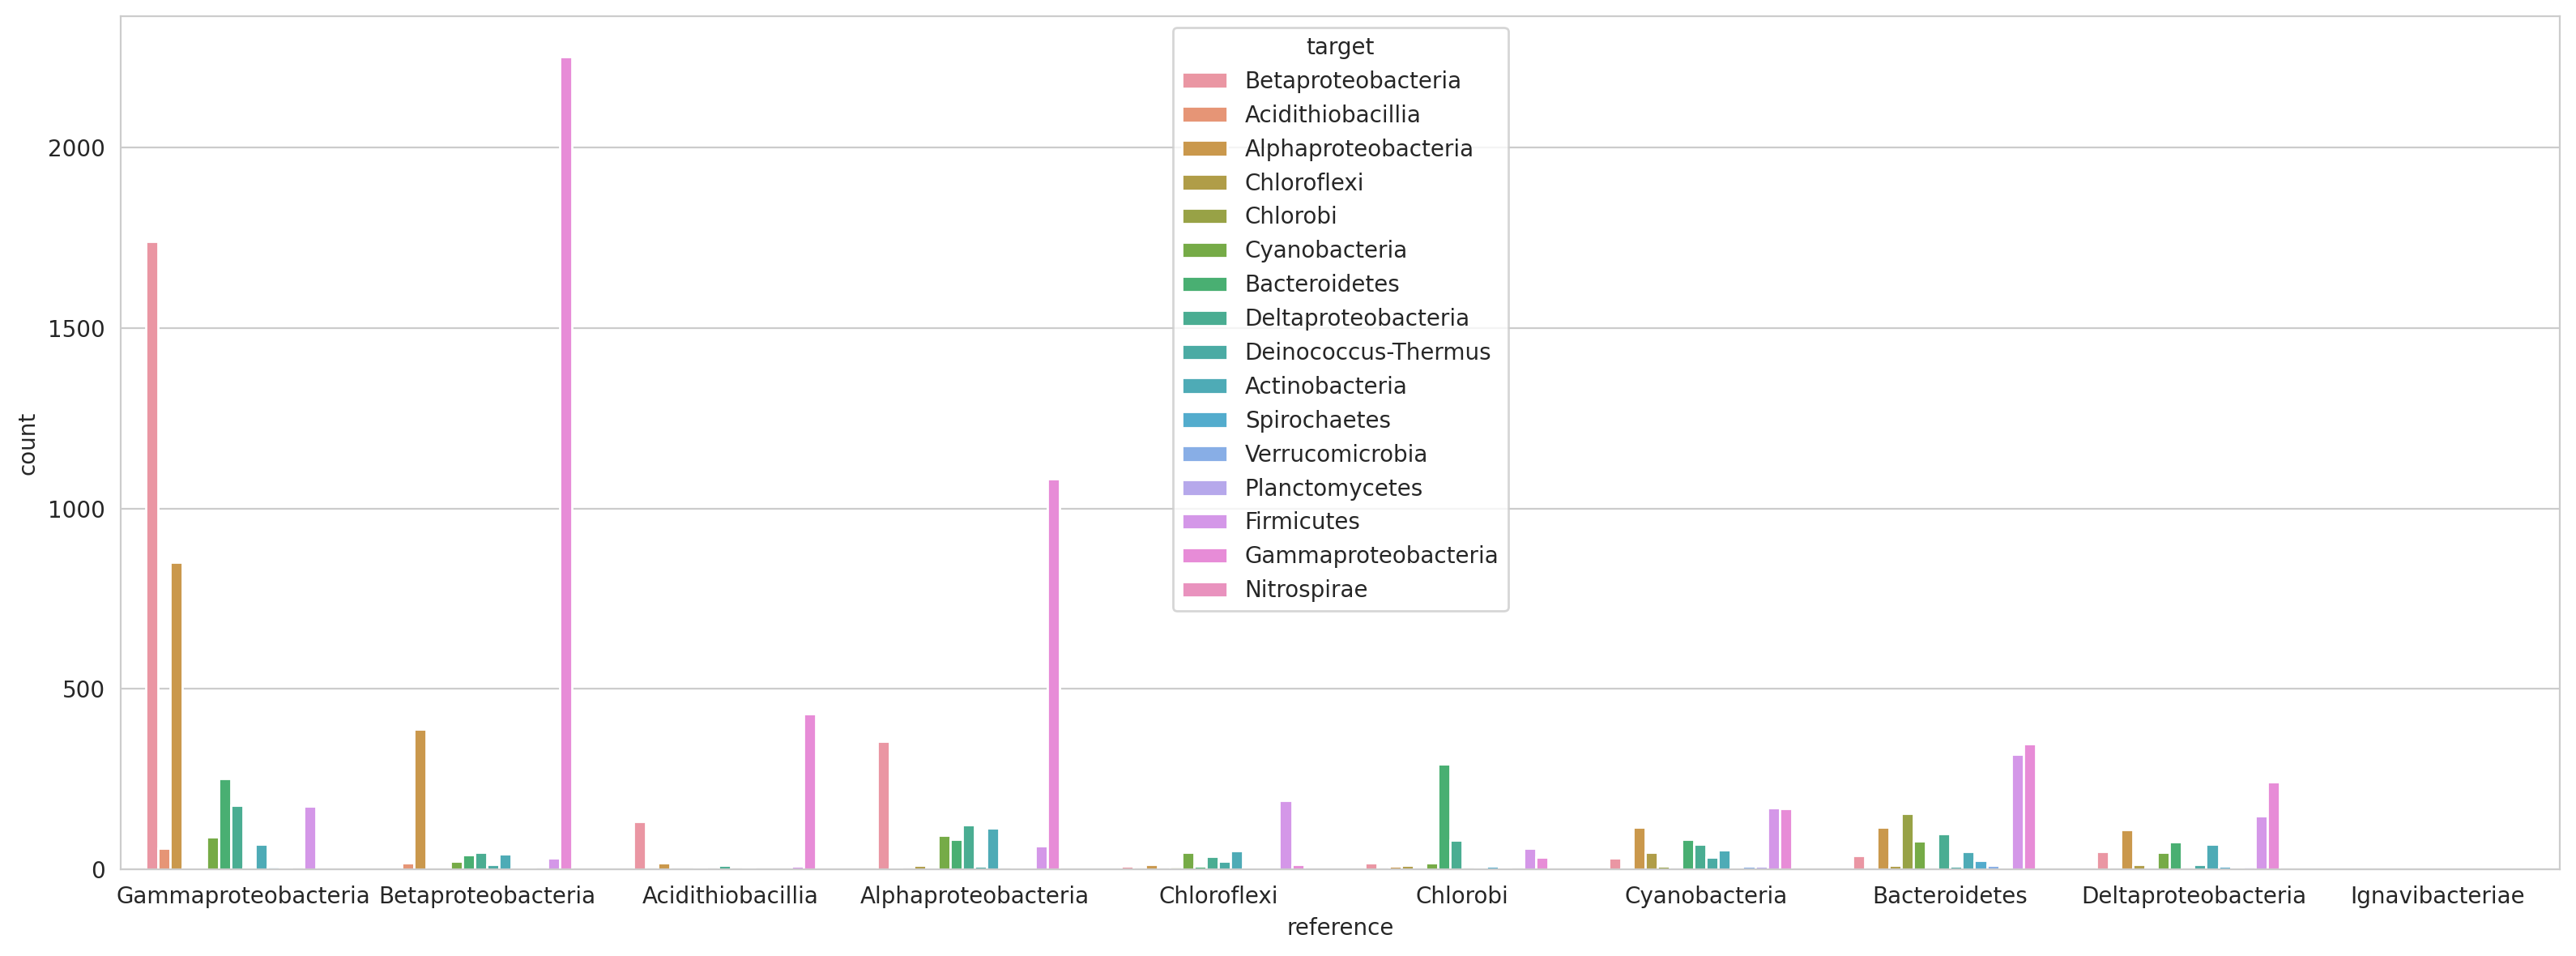

In [33]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(dpi=200, figsize=(16, 6))
    sns.barplot(x='reference', y='count', hue='target', data=closest_relation_freq, ax=ax)
    fig.tight_layout();

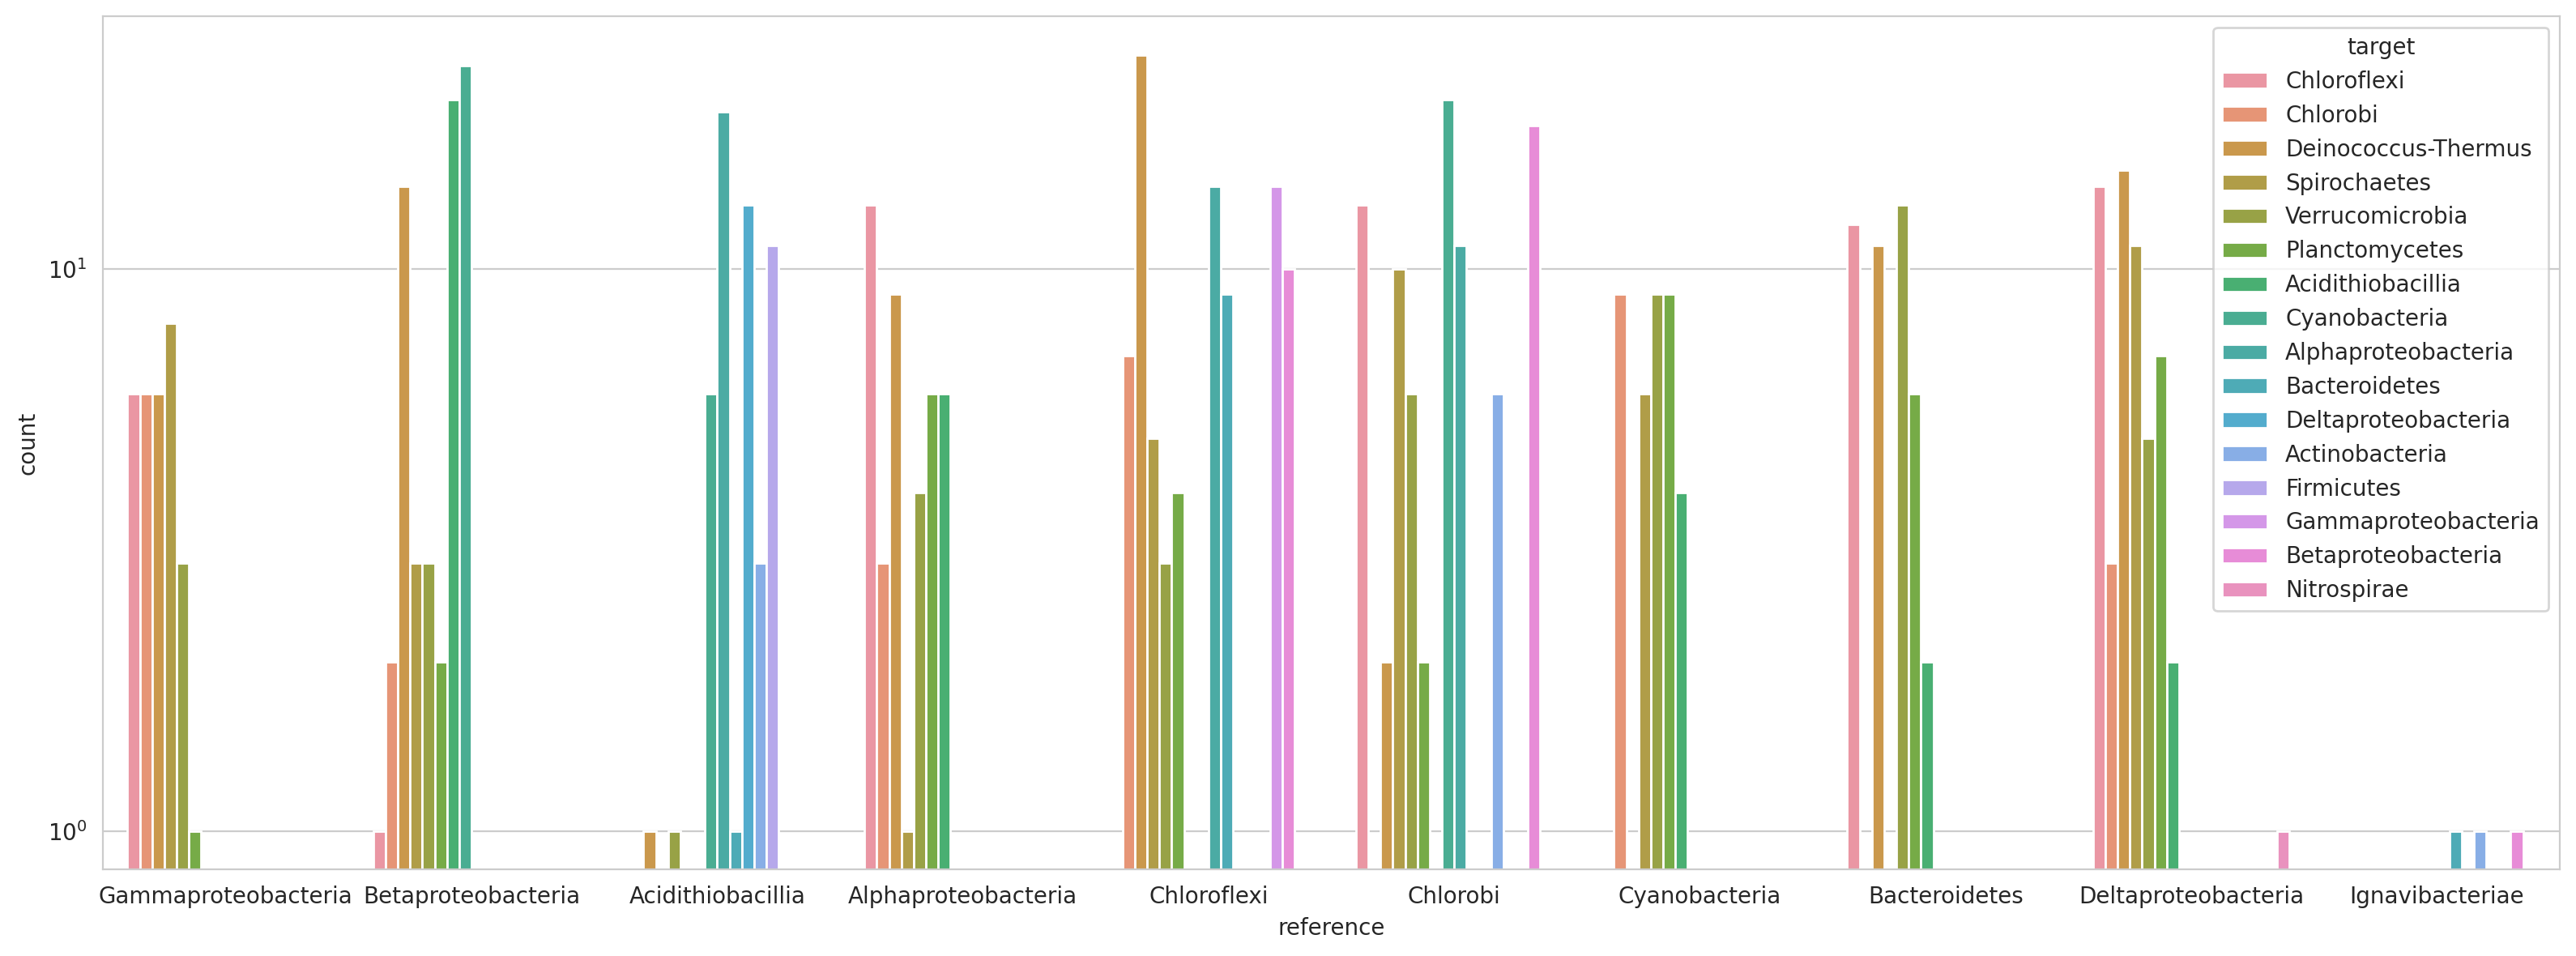

In [34]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(dpi=200, figsize=(16, 6))
    sns.barplot(x='reference', y='count', hue='target', data=closest_relation_freq.query('count<25'), ax=ax)
    ax.set(yscale="log")
    fig.tight_layout();

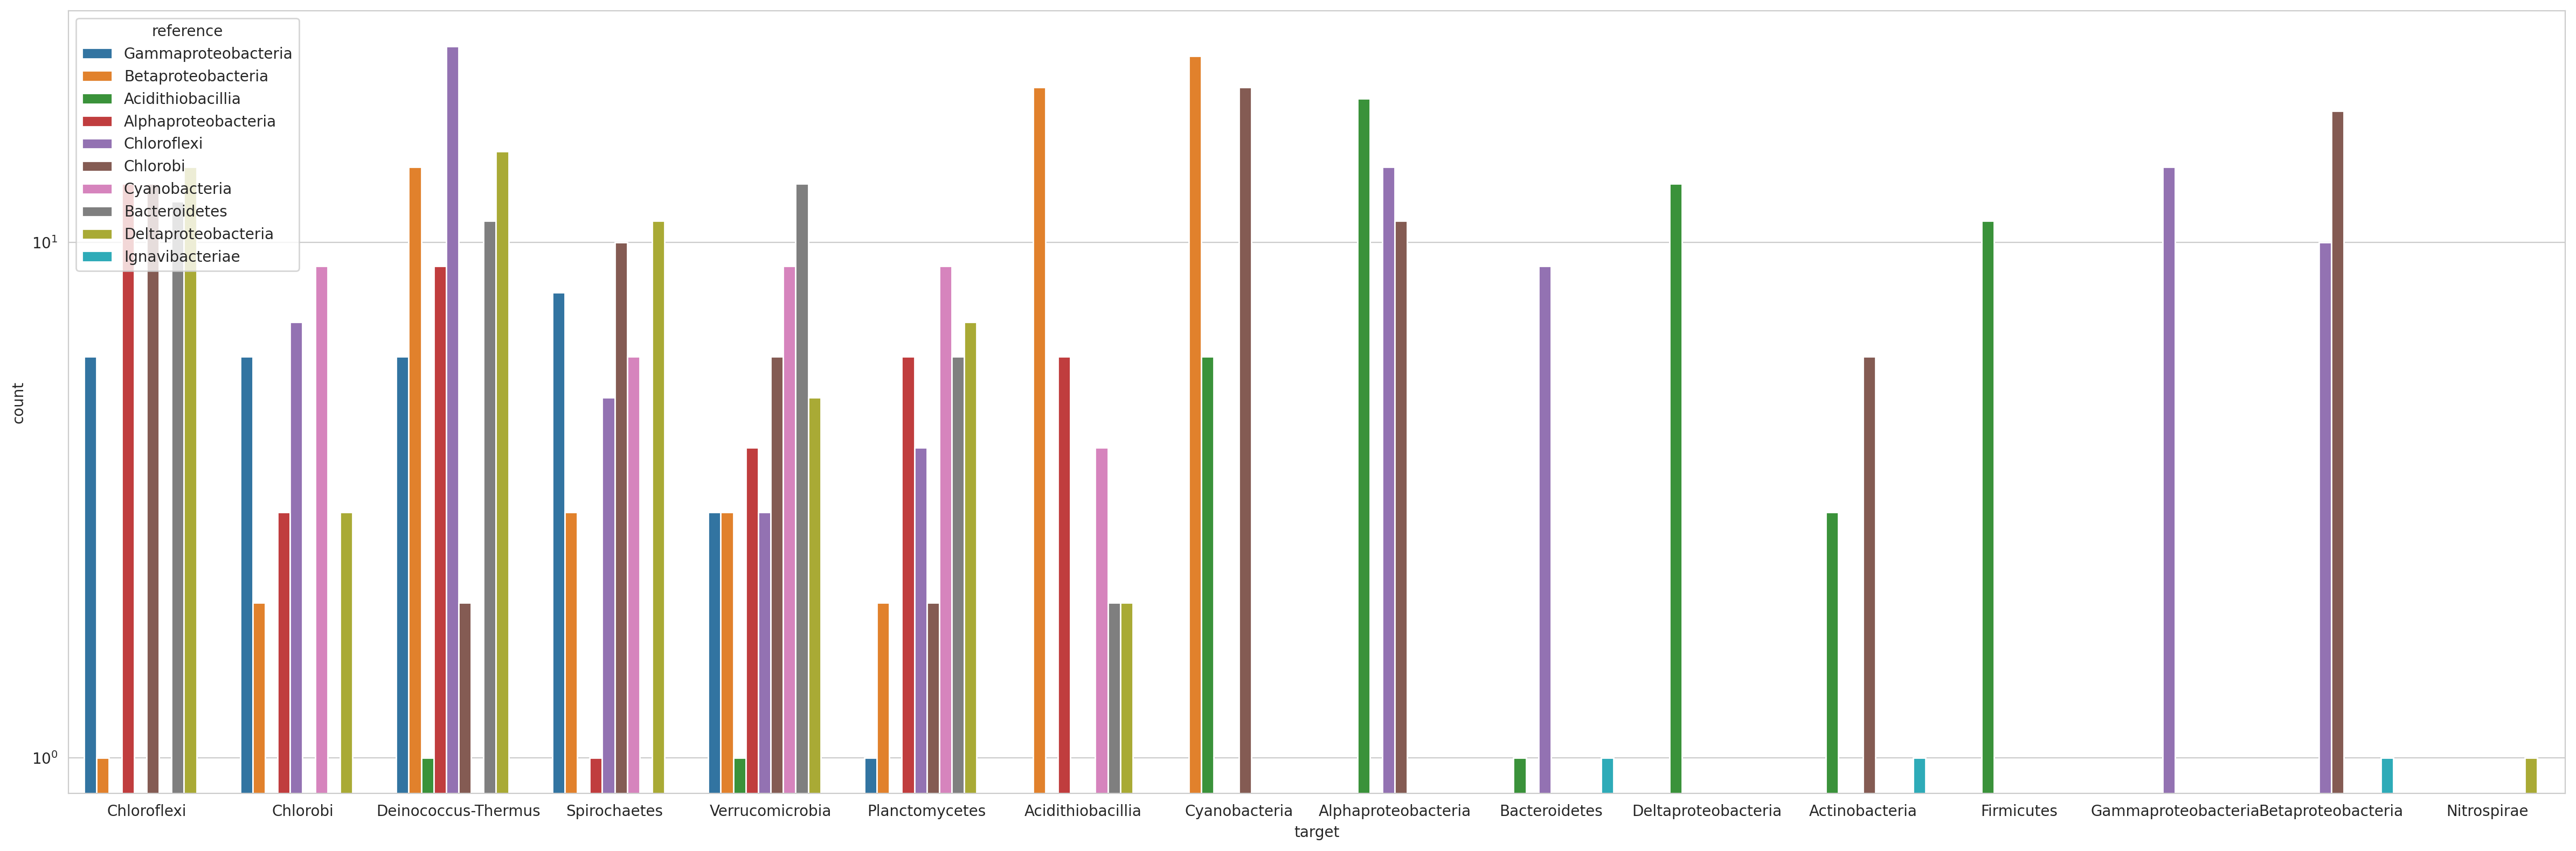

In [35]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(dpi=200, figsize=(24, 8))
    sns.barplot(x='target', y='count', hue='reference', data=closest_relation_freq.query('count<25'), ax=ax)
    ax.set(yscale="log")
    fig.tight_layout();

In [36]:
print(closest_relation_freq)

               reference               target   count
0    Gammaproteobacteria   Betaproteobacteria  1740.0
1    Gammaproteobacteria    Acidithiobacillia    59.0
2    Gammaproteobacteria  Alphaproteobacteria   850.0
3    Gammaproteobacteria          Chloroflexi     6.0
4    Gammaproteobacteria             Chlorobi     6.0
..                   ...                  ...     ...
119  Deltaproteobacteria           Firmicutes   150.0
120  Deltaproteobacteria          Nitrospirae     1.0
121      Ignavibacteriae   Betaproteobacteria     1.0
122      Ignavibacteriae        Bacteroidetes     1.0
123      Ignavibacteriae       Actinobacteria     1.0

[124 rows x 3 columns]


In [37]:
closest_relation_freq.query('count>400')

,reference,target,count
0,Gammaproteobacteria,Betaproteobacteria,1740.0
2,Gammaproteobacteria,Alphaproteobacteria,850.0
14,Betaproteobacteria,Gammaproteobacteria,2250.0
28,Acidithiobacillia,Gammaproteobacteria,431.0
38,Alphaproteobacteria,Gammaproteobacteria,1083.0


In [38]:
closest_relation_freq.query('count<400')

,reference,target,count
1,Gammaproteobacteria,Acidithiobacillia,59.0
3,Gammaproteobacteria,Chloroflexi,6.0
4,Gammaproteobacteria,Chlorobi,6.0
5,Gammaproteobacteria,Cyanobacteria,90.0
6,Gammaproteobacteria,Bacteroidetes,252.0
...,...,...,...
119,Deltaproteobacteria,Firmicutes,150.0
120,Deltaproteobacteria,Nitrospirae,1.0
121,Ignavibacteriae,Betaproteobacteria,1.0
122,Ignavibacteriae,Bacteroidetes,1.0


In [39]:
closest_relation_freq.query('reference.str.contains("Bacteroidetes") & count>400')

,reference,target,count


In [40]:
closest_relation_freq.query('reference.str.contains("Bacteroidetes") & count<400').sort_values(by='count')

,reference,target,count
94,Bacteroidetes,Acidithiobacillia,2.0
104,Bacteroidetes,Planctomycetes,6.0
100,Bacteroidetes,Deinococcus-Thermus,11.0
96,Bacteroidetes,Chloroflexi,12.0
103,Bacteroidetes,Verrucomicrobia,13.0
102,Bacteroidetes,Spirochaetes,25.0
93,Bacteroidetes,Betaproteobacteria,39.0
101,Bacteroidetes,Actinobacteria,50.0
98,Bacteroidetes,Cyanobacteria,79.0
99,Bacteroidetes,Deltaproteobacteria,99.0


In [41]:
#This will be the priority list for running the phyla pairs
closest_relation_freq.query('reference.str.contains("Bacteroidetes") & count<400').sort_values(by='count')

,reference,target,count
94,Bacteroidetes,Acidithiobacillia,2.0
104,Bacteroidetes,Planctomycetes,6.0
100,Bacteroidetes,Deinococcus-Thermus,11.0
96,Bacteroidetes,Chloroflexi,12.0
103,Bacteroidetes,Verrucomicrobia,13.0
102,Bacteroidetes,Spirochaetes,25.0
93,Bacteroidetes,Betaproteobacteria,39.0
101,Bacteroidetes,Actinobacteria,50.0
98,Bacteroidetes,Cyanobacteria,79.0
99,Bacteroidetes,Deltaproteobacteria,99.0


In [42]:
#This will be the priority list for running the phyla pairs
closest_relation_freq.query('target.str.contains("Spirochaetes")').sort_values(by='count')

,reference,target,count
48,Alphaproteobacteria,Spirochaetes,1.0
24,Betaproteobacteria,Spirochaetes,3.0
61,Chloroflexi,Spirochaetes,5.0
88,Cyanobacteria,Spirochaetes,6.0
10,Gammaproteobacteria,Spirochaetes,8.0
74,Chlorobi,Spirochaetes,10.0
116,Deltaproteobacteria,Spirochaetes,11.0
102,Bacteroidetes,Spirochaetes,25.0


In [43]:
#This will be the priority list for running the phyla pairs
closest_relation_freq.query('count<6').sort_values(by='count')

,reference,target,count
123,Ignavibacteriae,Actinobacteria,1.0
122,Ignavibacteriae,Bacteroidetes,1.0
48,Alphaproteobacteria,Spirochaetes,1.0
36,Acidithiobacillia,Verrucomicrobia,1.0
32,Acidithiobacillia,Bacteroidetes,1.0
34,Acidithiobacillia,Deinococcus-Thermus,1.0
121,Ignavibacteriae,Betaproteobacteria,1.0
17,Betaproteobacteria,Chloroflexi,1.0
12,Gammaproteobacteria,Planctomycetes,1.0
120,Deltaproteobacteria,Nitrospirae,1.0


In [79]:
#This will be the priority list for running the phyla pairs
#This will be the priority list for running the phyla pairs
closest_relation_freq.query('target.str.contains("Verru")').sort_values(by='count')

,reference,target,count
36,Acidithiobacillia,Verrucomicrobia,1.0
11,Gammaproteobacteria,Verrucomicrobia,3.0
25,Betaproteobacteria,Verrucomicrobia,3.0
62,Chloroflexi,Verrucomicrobia,3.0
49,Alphaproteobacteria,Verrucomicrobia,4.0
117,Deltaproteobacteria,Verrucomicrobia,5.0
75,Chlorobi,Verrucomicrobia,6.0
89,Cyanobacteria,Verrucomicrobia,9.0
103,Bacteroidetes,Verrucomicrobia,13.0


In [90]:
#Delta & Nitrospirae # 1 candidate.
#This will be the priority list for running the phyla pairs
#This will be the priority list for running the phyla pairs
closest_relation_freq.query('target.str.contains("Nitrospirae")').sort_values(by='count')

,reference,target,count
120,Deltaproteobacteria,Nitrospirae,1.0


In [70]:
closest_relation_freq.query('target.str.contains("Planctomycetes")').sort_values(by='count')

,reference,target,count
12,Gammaproteobacteria,Planctomycetes,1.0
26,Betaproteobacteria,Planctomycetes,2.0
76,Chlorobi,Planctomycetes,2.0
63,Chloroflexi,Planctomycetes,4.0
50,Alphaproteobacteria,Planctomycetes,6.0
104,Bacteroidetes,Planctomycetes,6.0
118,Deltaproteobacteria,Planctomycetes,7.0
90,Cyanobacteria,Planctomycetes,9.0


In [44]:
#This is a list of pairs with the "biggest lift" >100
closest_relation_freq.query('count>100').sort_values(by='count')

,reference,target,count
109,Deltaproteobacteria,Alphaproteobacteria,110.0
47,Alphaproteobacteria,Actinobacteria,116.0
95,Bacteroidetes,Alphaproteobacteria,117.0
81,Cyanobacteria,Alphaproteobacteria,118.0
45,Alphaproteobacteria,Deltaproteobacteria,124.0
29,Acidithiobacillia,Betaproteobacteria,134.0
119,Deltaproteobacteria,Firmicutes,150.0
97,Bacteroidetes,Chlorobi,155.0
78,Cyanobacteria,Gammaproteobacteria,169.0
91,Cyanobacteria,Firmicutes,172.0


In [24]:
#Export to excel -- turn off for additional runs beyond first
closest_relation_freq.sort_values(by='count').to_excel("add_phyla_5_30_21_closest_relation_freq.xlsx")

In [45]:
### Begin analysis

In [46]:
#
# fastTree
#

def assess_transfers_between_phyla(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('trees/%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)):
                  reconstruct_candidate_fastTree(candidate)

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('trees/%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('trees/%s-cluster%s.fastTree'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [47]:
def assess_transfers_between_phyla2(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('trees/%s-cluster%s.fastFigTree' % (group_id, cluster_num)):
                   visualize_reconstruct_candidate_fastTree2(candidate)

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('trees/%s-cluster%s.treefile.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('trees/%s-cluster%s.treefile'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [48]:
def assess_transfers_between_phyla3(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('trees/%s-cluster%s.treefile' % (group_id, cluster_num)):
                   reconstruct_candidate(candidate)

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('trees/%s-cluster%s.treefile.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('trees/%s-cluster%s.treefile'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [28]:
#Example of pipeline -- reconstruct & visualize
#
#reconstruct_candidate_fastTree('COG0049#3')
#visualize_reconstruct_candidate_fastTree2('COG0049#3')
#
# # descriptions = assess_transfers_between_phyla((200795, 1117))

In [85]:
print(sampled_phyla)

[1236, 28216, 1807140, 28211, 200795, 1090, 1117, 976, 28221, 1134404, 1297, 201174, 203691, 74201, 203682, 1239, 40117, 1293497]


In [30]:
for each in itertools.combinations(sampled_phyla, 2):
    print(each)

(1236, 28216)
(1236, 1807140)
(1236, 28211)
(1236, 200795)
(1236, 1090)
(1236, 1117)
(1236, 976)
(1236, 28221)
(1236, 1134404)
(1236, 1297)
(1236, 201174)
(1236, 203691)
(1236, 74201)
(1236, 203682)
(1236, 1239)
(1236, 40117)
(1236, 1293497)
(28216, 1807140)
(28216, 28211)
(28216, 200795)
(28216, 1090)
(28216, 1117)
(28216, 976)
(28216, 28221)
(28216, 1134404)
(28216, 1297)
(28216, 201174)
(28216, 203691)
(28216, 74201)
(28216, 203682)
(28216, 1239)
(28216, 40117)
(28216, 1293497)
(1807140, 28211)
(1807140, 200795)
(1807140, 1090)
(1807140, 1117)
(1807140, 976)
(1807140, 28221)
(1807140, 1134404)
(1807140, 1297)
(1807140, 201174)
(1807140, 203691)
(1807140, 74201)
(1807140, 203682)
(1807140, 1239)
(1807140, 40117)
(1807140, 1293497)
(28211, 200795)
(28211, 1090)
(28211, 1117)
(28211, 976)
(28211, 28221)
(28211, 1134404)
(28211, 1297)
(28211, 201174)
(28211, 203691)
(28211, 74201)
(28211, 203682)
(28211, 1239)
(28211, 40117)
(28211, 1293497)
(200795, 1090)
(200795, 1117)
(200795, 976)
(

In [89]:
for each in itertools.combinations(sampled_phyla, 2):
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] for phylum in each}
    print(phylum_names)
    print(each)

{1236: 'Gammaproteobacteria', 28216: 'Betaproteobacteria'}
(1236, 28216)
{1236: 'Gammaproteobacteria', 1807140: 'Acidithiobacillia'}
(1236, 1807140)
{1236: 'Gammaproteobacteria', 28211: 'Alphaproteobacteria'}
(1236, 28211)
{1236: 'Gammaproteobacteria', 200795: 'Chloroflexi'}
(1236, 200795)
{1236: 'Gammaproteobacteria', 1090: 'Chlorobi'}
(1236, 1090)
{1236: 'Gammaproteobacteria', 1117: 'Cyanobacteria'}
(1236, 1117)
{1236: 'Gammaproteobacteria', 976: 'Bacteroidetes'}
(1236, 976)
{1236: 'Gammaproteobacteria', 28221: 'Deltaproteobacteria'}
(1236, 28221)
{1236: 'Gammaproteobacteria', 1134404: 'Ignavibacteriae'}
(1236, 1134404)
{1236: 'Gammaproteobacteria', 1297: 'Deinococcus-Thermus'}
(1236, 1297)
{1236: 'Gammaproteobacteria', 201174: 'Actinobacteria'}
(1236, 201174)
{1236: 'Gammaproteobacteria', 203691: 'Spirochaetes'}
(1236, 203691)
{1236: 'Gammaproteobacteria', 74201: 'Verrucomicrobia'}
(1236, 74201)
{1236: 'Gammaproteobacteria', 203682: 'Planctomycetes'}
(1236, 203682)
{1236: 'Gammaprot

{201174: 'Actinobacteria', 203682: 'Planctomycetes'}
(201174, 203682)
{201174: 'Actinobacteria', 1239: 'Firmicutes'}
(201174, 1239)
{201174: 'Actinobacteria', 40117: 'Nitrospirae'}
(201174, 40117)
{201174: 'Actinobacteria', 1293497: 'Nitrospinae'}
(201174, 1293497)
{203691: 'Spirochaetes', 74201: 'Verrucomicrobia'}
(203691, 74201)
{203691: 'Spirochaetes', 203682: 'Planctomycetes'}
(203691, 203682)
{203691: 'Spirochaetes', 1239: 'Firmicutes'}
(203691, 1239)
{203691: 'Spirochaetes', 40117: 'Nitrospirae'}
(203691, 40117)
{203691: 'Spirochaetes', 1293497: 'Nitrospinae'}
(203691, 1293497)
{74201: 'Verrucomicrobia', 203682: 'Planctomycetes'}
(74201, 203682)
{74201: 'Verrucomicrobia', 1239: 'Firmicutes'}
(74201, 1239)
{74201: 'Verrucomicrobia', 40117: 'Nitrospirae'}
(74201, 40117)
{74201: 'Verrucomicrobia', 1293497: 'Nitrospinae'}
(74201, 1293497)
{203682: 'Planctomycetes', 1239: 'Firmicutes'}
(203682, 1239)
{203682: 'Planctomycetes', 40117: 'Nitrospirae'}
(203682, 40117)
{203682: 'Planctomyc

In [31]:
print(sampled_phyla)

[1236, 28216, 1807140, 28211, 200795, 1090, 1117, 976, 28221, 1134404, 1297, 201174, 203691, 74201, 203682, 1239, 40117, 1293497]


In [32]:
#Unique selected phyla/class pairings for run1
#(28216, 200795)
#(28211, 1090)
#(1236, 200795)
#(28216, 1090)
#(28211, 200795)
#(1236, 1090)
#(200795, 28221)
#(28216, 1117)
#(1090, 28221)
#(28216, 28221)
#(1117, 28221)
#(28211, 1117)
#(28211, 28221)
#(1236, 1117)
#
# Focus on Beta, Delta, Alpha, Gamma pairings first
#
# (28216, 976)
# (976, 28221)
# (28211, 976)
# (1236, 976)
# (200795,976)
# (1117,976)
# (1090,976)
# Acidithio removed from list

In [33]:
old_sub_sampled_phyla = ((28216, 200795),
                     (28211, 1090),
                     (1236, 200795),
                     (28216, 1090),
                     (28211, 200795),
                     (1236, 1090),
                     (200795, 28221),
                     (28216, 1117),
                     (1090, 28221),
                     (28216, 28221),
                     (1117, 28221),
                     (28211, 1117),
                     (28211, 28221),
                     (1236, 1117))

In [34]:
#Pick the specific Bacteroidetes to Proteobacteria classes you want to run
#sub_sampled_phyla = ((28216, 976),
#                    (976, 28221),
#                    (28211, 976),
#                    (1236, 976),
#                    (200795,976),
#                    (1117,976),
#                    (1090,976))

In [35]:
old_sub_sampled_phyla = ((28216, 976),
                    (976, 28221),
                    (28211, 976),
                    (1236, 976))

In [36]:
sub_sampled_phyla = ((1236, 203691),
(28216, 203691),
(1807140, 203691),
(28211, 203691),
(200795, 203691),
(1090, 203691),
(1117, 203691),
(976, 203691),
(28221, 203691),
(1134404, 203691),
(1297, 203691),
(201174, 203691),
(203691, 74201),
(203691, 203682),
(203691, 1239),
(203691, 40117),
(203691, 1293497))

In [95]:
# Verru 74201 # Plancto 203682 # Nitro delta

new_sub_sampled_phyla = ((1236, 74201),
(28216, 74201),
(1807140, 74201),
(28211, 74201),
(200795, 74201),
(1090, 74201),
(1117, 74201),
(976, 74201),
(28221, 74201),
(1134404, 74201),
(1297, 74201),
(201174, 74201),
(203691, 74201),
(74201, 203682),
(74201, 1239),
(74201, 40117),
(74201, 1293497),
(1236, 203682),
(28216, 203682),
(1807140, 203682),
(28211, 203682),
(200795, 203682),
(1090, 203682),
(1117, 203682),
(976, 203682),
(28221, 203682),
(1134404, 203682),
(1297, 203682),
(201174, 203682),
(203691, 203682),
(74201, 203682),
(203682, 1239),
(203682, 40117),
(203682, 1293497),
(28221, 40117))

In [98]:
%cd /nobackup1b/users/payette/eggNOGbyClass3

/nobackup1c/users/payette/eggNOGbyClass3


In [99]:
#Run assess_transfers for Fast Trees
descriptions_new = {}
for phylum_pair in new_sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions_new[phylum_pair] = assess_transfers_between_phyla(phylum_pair) #assess transfers, then reconstruct

{1236: 'Gammaproteobacteria', 74201: 'Verrucomicrobia'}
(1236, 74201)
{28216: 'Betaproteobacteria', 74201: 'Verrucomicrobia'}
(28216, 74201)
{1807140: 'Acidithiobacillia', 74201: 'Verrucomicrobia'}
(1807140, 74201)
{28211: 'Alphaproteobacteria', 74201: 'Verrucomicrobia'}
(28211, 74201)
{200795: 'Chloroflexi', 74201: 'Verrucomicrobia'}
(200795, 74201)
{1090: 'Chlorobi', 74201: 'Verrucomicrobia'}
(1090, 74201)
{1117: 'Cyanobacteria', 74201: 'Verrucomicrobia'}
(1117, 74201)
{976: 'Bacteroidetes', 74201: 'Verrucomicrobia'}
(976, 74201)
{28221: 'Deltaproteobacteria', 74201: 'Verrucomicrobia'}
(28221, 74201)
{1134404: 'Ignavibacteriae', 74201: 'Verrucomicrobia'}
(1134404, 74201)
{1297: 'Deinococcus-Thermus', 74201: 'Verrucomicrobia'}
(1297, 74201)
{201174: 'Actinobacteria', 74201: 'Verrucomicrobia'}
(201174, 74201)
{203691: 'Spirochaetes', 74201: 'Verrucomicrobia'}
(203691, 74201)
{74201: 'Verrucomicrobia', 203682: 'Planctomycetes'}
(74201, 203682)
{74201: 'Verrucomicrobia', 1239: 'Firmicute

In [92]:
#new_sampled_phyla = [(28221, 1239)]

In [97]:
!pwd

/nobackup1c/users/payette/eggNOGbyClass3/candidates


In [40]:
### Manually cut to Firmcutes run, saved data below:

In [33]:
for phylum_pair in sub_sampled_phyla:
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)

{1236: 'Gammaproteobacteria', 203691: 'Spirochaetes'}
(1236, 203691)
{28216: 'Betaproteobacteria', 203691: 'Spirochaetes'}
(28216, 203691)
{1807140: 'Acidithiobacillia', 203691: 'Spirochaetes'}
(1807140, 203691)
{28211: 'Alphaproteobacteria', 203691: 'Spirochaetes'}
(28211, 203691)
{200795: 'Chloroflexi', 203691: 'Spirochaetes'}
(200795, 203691)
{1090: 'Chlorobi', 203691: 'Spirochaetes'}
(1090, 203691)
{1117: 'Cyanobacteria', 203691: 'Spirochaetes'}
(1117, 203691)
{976: 'Bacteroidetes', 203691: 'Spirochaetes'}
(976, 203691)
{28221: 'Deltaproteobacteria', 203691: 'Spirochaetes'}
(28221, 203691)
{1134404: 'Ignavibacteriae', 203691: 'Spirochaetes'}
(1134404, 203691)
{1297: 'Deinococcus-Thermus', 203691: 'Spirochaetes'}
(1297, 203691)
{201174: 'Actinobacteria', 203691: 'Spirochaetes'}
(201174, 203691)
{203691: 'Spirochaetes', 74201: 'Verrucomicrobia'}
(203691, 74201)
{203691: 'Spirochaetes', 203682: 'Planctomycetes'}
(203691, 203682)
{203691: 'Spirochaetes', 1239: 'Firmicutes'}
(203691, 12

In [34]:
#Test run with Spirochaetes

In [35]:
#Run assess_transfers for Fast Trees
descriptions = {}
for phylum_pair in sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions[phylum_pair] = assess_transfers_between_phyla(phylum_pair) #assess transfers, then reconstruct

{1236: 'Gammaproteobacteria', 203691: 'Spirochaetes'}
(1236, 203691)
{28216: 'Betaproteobacteria', 203691: 'Spirochaetes'}
(28216, 203691)
{1807140: 'Acidithiobacillia', 203691: 'Spirochaetes'}
(1807140, 203691)
{28211: 'Alphaproteobacteria', 203691: 'Spirochaetes'}
(28211, 203691)
{200795: 'Chloroflexi', 203691: 'Spirochaetes'}
(200795, 203691)
{1090: 'Chlorobi', 203691: 'Spirochaetes'}
(1090, 203691)
{1117: 'Cyanobacteria', 203691: 'Spirochaetes'}
(1117, 203691)
{976: 'Bacteroidetes', 203691: 'Spirochaetes'}
(976, 203691)
{28221: 'Deltaproteobacteria', 203691: 'Spirochaetes'}
(28221, 203691)
{1134404: 'Ignavibacteriae', 203691: 'Spirochaetes'}
(1134404, 203691)
{1297: 'Deinococcus-Thermus', 203691: 'Spirochaetes'}
(1297, 203691)
{201174: 'Actinobacteria', 203691: 'Spirochaetes'}
(201174, 203691)
{203691: 'Spirochaetes', 74201: 'Verrucomicrobia'}
(203691, 74201)
{203691: 'Spirochaetes', 203682: 'Planctomycetes'}
(203691, 203682)
{203691: 'Spirochaetes', 1239: 'Firmicutes'}
(203691, 12

In [36]:
for pair, description in descriptions.items():
    print(pair)
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in pair}
    print(phylum_names)
    for key, value in description.items():
        print(key, len(value))
    print()

(1236, 203691)
{1236: 'Gammaproteobacteria', 203691: 'Spirochaetes'}
from 1236 to 203691 2
from 203691 to 1236 4
sisters 0
no clear relationship between phyla 3

(28216, 203691)
{28216: 'Betaproteobacteria', 203691: 'Spirochaetes'}
from 28216 to 203691 0
from 203691 to 28216 0
sisters 1
no clear relationship between phyla 2

(1807140, 203691)
{1807140: 'Acidithiobacillia', 203691: 'Spirochaetes'}
from 1807140 to 203691 0
from 203691 to 1807140 0
sisters 0
no clear relationship between phyla 0

(28211, 203691)
{28211: 'Alphaproteobacteria', 203691: 'Spirochaetes'}
from 28211 to 203691 1
from 203691 to 28211 0
sisters 0
no clear relationship between phyla 0

(200795, 203691)
{200795: 'Chloroflexi', 203691: 'Spirochaetes'}
from 200795 to 203691 2
from 203691 to 200795 0
sisters 0
no clear relationship between phyla 3

(1090, 203691)
{1090: 'Chlorobi', 203691: 'Spirochaetes'}
from 1090 to 203691 0
from 203691 to 1090 2
sisters 3
no clear relationship between phyla 5

(1117, 203691)
{1117: 

In [37]:
# Old code to print descriptions and COGs from output of assess_transfers
#
for pair, description in descriptions.items():
    print(pair)
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in pair}
    print(phylum_names)
    for key, value in description.items():
        print(key, value)
    print()

(1236, 203691)
{1236: 'Gammaproteobacteria', 203691: 'Spirochaetes'}
from 1236 to 203691 {'COG1521#1 from 1236 to 146', 'COG1521#1 from 1236 to 157'}
from 203691 to 1236 {'COG1921#1 from 203692 to 1236', 'COG0073#1 from 157 to 1236', 'COG1577#4 from 136 to 45064', 'COG3276#1 from 203692 to 1236'}
sisters set()
no clear relationship between phyla {'COG0313#0', 'COG2976#0', 'COG0108#3'}

(28216, 203691)
{28216: 'Betaproteobacteria', 203691: 'Spirochaetes'}
from 28216 to 203691 set()
from 203691 to 28216 set()
sisters {'COG0252#2'}
no clear relationship between phyla {'COG2236#2', 'COG0690#0'}

(1807140, 203691)
{1807140: 'Acidithiobacillia', 203691: 'Spirochaetes'}
from 1807140 to 203691 set()
from 203691 to 1807140 set()
sisters set()
no clear relationship between phyla set()

(28211, 203691)
{28211: 'Alphaproteobacteria', 203691: 'Spirochaetes'}
from 28211 to 203691 {'COG5323#2 from 28211 to 157'}
from 203691 to 28211 set()
sisters set()
no clear relationship between phyla set()

(2007

In [86]:
#Ensure you're in the root directory of the distHGT project folder and not candidates
os.chdir('/nobackup1c/users/payette/eggNOGbyClass3/')
!pwd

/nobackup1c/users/payette/eggNOGbyClass3


In [87]:
#Visualize fast trees
descriptions2 = {}
for phylum_pair in sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions2[phylum_pair] = assess_transfers_between_phyla2(phylum_pair) #assess transfers, then reconstruct

{1236: 'Gammaproteobacteria', 203691: 'Spirochaetes'}
(1236, 203691)
{28216: 'Betaproteobacteria', 203691: 'Spirochaetes'}
(28216, 203691)
{1807140: 'Acidithiobacillia', 203691: 'Spirochaetes'}
(1807140, 203691)
{28211: 'Alphaproteobacteria', 203691: 'Spirochaetes'}
(28211, 203691)
{200795: 'Chloroflexi', 203691: 'Spirochaetes'}
(200795, 203691)
{1090: 'Chlorobi', 203691: 'Spirochaetes'}
(1090, 203691)
{1117: 'Cyanobacteria', 203691: 'Spirochaetes'}
(1117, 203691)
{976: 'Bacteroidetes', 203691: 'Spirochaetes'}
(976, 203691)
{28221: 'Deltaproteobacteria', 203691: 'Spirochaetes'}
(28221, 203691)
{1134404: 'Ignavibacteriae', 203691: 'Spirochaetes'}
(1134404, 203691)
{1297: 'Deinococcus-Thermus', 203691: 'Spirochaetes'}
(1297, 203691)
{201174: 'Actinobacteria', 203691: 'Spirochaetes'}
(201174, 203691)
{203691: 'Spirochaetes', 74201: 'Verrucomicrobia'}
(203691, 74201)
{203691: 'Spirochaetes', 203682: 'Planctomycetes'}
(203691, 203682)
{203691: 'Spirochaetes', 1239: 'Firmicutes'}
(203691, 12

In [90]:
# Run IQtrees
descriptions3 = {}
for phylum_pair in sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions3[phylum_pair] = assess_transfers_between_phyla3(phylum_pair) #assess transfers, then reconstruct

{1236: 'Gammaproteobacteria', 203691: 'Spirochaetes'}
(1236, 203691)
{28216: 'Betaproteobacteria', 203691: 'Spirochaetes'}
(28216, 203691)
{1807140: 'Acidithiobacillia', 203691: 'Spirochaetes'}
(1807140, 203691)
{28211: 'Alphaproteobacteria', 203691: 'Spirochaetes'}
(28211, 203691)
{200795: 'Chloroflexi', 203691: 'Spirochaetes'}
(200795, 203691)
{1090: 'Chlorobi', 203691: 'Spirochaetes'}
(1090, 203691)
{1117: 'Cyanobacteria', 203691: 'Spirochaetes'}
(1117, 203691)
{976: 'Bacteroidetes', 203691: 'Spirochaetes'}
(976, 203691)
{28221: 'Deltaproteobacteria', 203691: 'Spirochaetes'}
(28221, 203691)
{1134404: 'Ignavibacteriae', 203691: 'Spirochaetes'}
(1134404, 203691)
{1297: 'Deinococcus-Thermus', 203691: 'Spirochaetes'}
(1297, 203691)
{201174: 'Actinobacteria', 203691: 'Spirochaetes'}
(201174, 203691)
{203691: 'Spirochaetes', 74201: 'Verrucomicrobia'}
(203691, 74201)
{203691: 'Spirochaetes', 203682: 'Planctomycetes'}
(203691, 203682)
{203691: 'Spirochaetes', 1239: 'Firmicutes'}
(203691, 12

In [ ]:
#Visualize IQtrees by hand!

In [ ]:
###########
#
#  INSERT CODE HERE< FORM ABOVE

In [41]:
### Run Firmicutes and Deltas

In [42]:
for phylum_pair in [(28221, 1239)]:
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)

{28221: 'Deltaproteobacteria', 1239: 'Firmicutes'}
(28221, 1239)


In [43]:
#Run assess_transfers for Fast Trees
descriptions2 = {}
for phylum_pair in [(28221, 1239)]:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions2[phylum_pair] = assess_transfers_between_phyla(phylum_pair) #assess transfers, then reconstruct

{28221: 'Deltaproteobacteria', 1239: 'Firmicutes'}
(28221, 1239)


In [44]:
for pair, description in descriptions2.items():
    print(pair)
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in pair}
    print(phylum_names)
    for key, value in description2.items():
        print(key, value)
    print()

(28221, 1239)
{28221: 'Deltaproteobacteria', 1239: 'Firmicutes'}
from 28221 to 1239 {'COG0626#0 from 29 to 86959', 'COG1416#0 from 28221 to 1578', 'COG1416#0 from 28221 to 184064', 'COG4913#2', 'COG1775#6 from 28221 to 29362', 'COG1139#3 from 213119 to 186807', 'COG1053#8', 'COG0626#0 from 29 to 57037', 'COG2703#2 from 28221 to 186802', 'COG0291#1 from 28221 to 97138', 'COG0291#1', 'COG3945#4', 'COG2873#0', 'COG0740#1', 'COG0376#1', 'COG0291#1 from 28221 to 427926', 'COG1592#3', 'COG0740#1 from 28221 to 972', 'COG0160#4 from 28221 to 1035308', 'COG1775#6 from 28221 to 186801', 'COG1620#6', 'COG1775#6 from 28221 to 102134', 'COG0403#1 from 28221 to 184064', 'COG1038#2 from 28221 to 1385', 'COG1775#6 from 28221 to 86170', 'COG1071#3'}
from 1239 to 28221 {'COG0769#0 from 1239 to 117942', 'COG1564#0', 'COG3382#1 from 1239 to 194924', 'COG0599#4 from 186802 to 28221', 'COG4279#1 from 1239 to 29', 'COG3086#0', 'COG3469#5 from 1239 to 29', 'COG1387#3', 'COG3500#1', 'COG2315#0 from 1239 to 194

In [ ]:
# Save descriptions to disk
with open('Delta_Firmicutes', 'wb') as out:
    pkl.dump(descriptions2, out)

In [45]:
#Visualize fast trees
descriptions2_a = {}
for phylum_pair in [(28221, 1239)]:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions2_a[phylum_pair] = assess_transfers_between_phyla2(phylum_pair) #assess transfers, then reconstruct

{28221: 'Deltaproteobacteria', 1239: 'Firmicutes'}
(28221, 1239)


In [ ]:
# Run IQtrees
descriptions3_a = {}
for phylum_pair in [(28221, 1239)]:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions3_a[phylum_pair] = assess_transfers_between_phyla3(phylum_pair) #assess transfers, then reconstruct

{28221: 'Deltaproteobacteria', 1239: 'Firmicutes'}
(28221, 1239)


In [3]:
!pwd

/nobackup1c/users/payette/eggNOGbyClass3


In [4]:
#Visualize IQtrees by hand!

In [14]:
!cd /nobackup1c/users/payette/eggNOGbyClass3/candidates/
os.chdir('/nobackup1c/users/payette/eggNOGbyClass3/candidates/')
!pwd

/nobackup1c/users/payette/eggNOGbyClass3/candidates


In [6]:
COGs = pd.read_excel('COGs.xlsx')

In [7]:
for each in COGs.COG:
    print(each)

nan
nan
nan
COG0626#0
COG1416#0
COG1416#0
COG4913#2
COG1775#6
COG1139#3
COG1053#8
COG0626#0
COG2703#2
COG0291#1
COG0291#1
COG3945#4
COG2873#0
COG0740#1
COG0376#1
COG0291#1
COG1592#3
COG0740#1
COG0160#4
COG1775#6
COG1620#6
COG0403#1
COG1038#2
COG1775#6
COG1071#3
nan
COG0769#0
COG1564#0
COG3382#1
COG0599#4
COG4279#1
COG3086#0
COG3469#5
COG1387#3
COG3500#1
COG2315#0
COG4656#7
COG1148#1
COG1757#3
COG1906#1
COG1964#2
COG0160#4
COG0716#3
COG0468#8
COG3004#3
COG3948#0
COG0151#2
COG3214#1
COG0569#3
COG1284#0
COG2768#2
COG0850#1
COG1346#2
COG1013#8
COG1009#5
COG0117#3
COG1148#1
COG1988#1
2Z80P#0
COG4822#0
COG1811#0
COG0631#2
COG2316#2
COG0580#0
COG0151#2
COG3051#0+A94
COG0403#1
COG2703#2
COG2363#2
COG4954#0
COG2501#0
COG0853#3
COG1723#4
COG0850#1
COG0340#2
COG0327#1
COG2265#2
COG0403#1
COG1914#8
COG0164#2
COG0214#1
COG0340#2
COG1619#0
COG1974#1
COG0327#1
COG4637#1
COG1139#3
COG0674#1
COG5401#2
COG1619#0
COG0569#3
COG2720#0
COG1085#1
COG3469#5
COG0327#1
COG3979#0
COG0626#0
COG0597#2
COG0816#0
CO

In [8]:
for each in COGs.COG:
    print(each)
    try:
        visualize_reconstructed_candidate2(each)
    except:
        print('Error for: ',each)

nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
COG0626#0
COG1416#0
COG1416#0
COG4913#2
COG1775#6
COG1139#3
COG1053#8
COG0626#0
COG2703#2
COG0291#1
COG0291#1
COG3945#4
COG2873#0
COG0740#1
missing treefile or rooting:  COG0740#1
COG0376#1
COG0291#1
COG1592#3
COG0740#1
missing treefile or rooting:  COG0740#1
COG0160#4
COG1775#6
COG1620#6
COG0403#1
COG1038#2
COG1775#6
COG1071#3
nan
Error for:  nan
COG0769#0
COG1564#0
COG3382#1
COG0599#4
COG4279#1
COG3086#0
COG3469#5
COG1387#3
COG3500#1
COG2315#0
COG4656#7
COG1148#1
COG1757#3
COG1906#1
COG1964#2
COG0160#4
COG0716#3
COG0468#8
COG3004#3
COG3948#0
COG0151#2
COG3214#1
COG0569#3
COG1284#0
COG2768#2
COG0850#1
COG1346#2
COG1013#8
COG1009#5
COG0117#3
COG1148#1
COG1988#1
2Z80P#0
COG4822#0
COG1811#0
COG0631#2
COG2316#2
COG0580#0
COG0151#2
COG3051#0+A94
missing treefile or rooting:  COG3051#0+A94
COG0403#1
COG2703#2
COG2363#2
COG4954#0
COG2501#0
COG0853#3
COG1723#4
COG0850#1
COG0340#2
COG0327#1
COG2265#2
COG0403#1
COG1914#8
COG0164#2
COG0

In [9]:
visualize_reconstructed_candidate2('COG3051#0')

In [43]:
visualize_reconstructed_candidate2('COG0626#0') #visualizer has custom colors that can be activated

In [44]:
visualize_reconstructed_candidate2('COG1416#0')

In [45]:
visualize_reconstructed_candidate2('COG4913#2')

In [46]:
visualize_reconstructed_candidate2('COG1775#6')

In [47]:
visualize_reconstructed_candidate2('COG1139#3')

In [48]:
visualize_reconstructed_candidate2('COG1053#8')

In [49]:
visualize_reconstructed_candidate2('COG2703#2')

In [50]:
visualize_reconstructed_candidate2('COG0291#1')

In [51]:
visualize_reconstructed_candidate2('COG3945#4')

In [52]:
visualize_reconstructed_candidate2('COG2873#0')

In [53]:
visualize_reconstructed_candidate2('COG0740#1')#

missing treefile or rooting:  COG0740#1


In [54]:
visualize_reconstructed_candidate2('COG0376#1')

In [55]:
visualize_reconstructed_candidate2('COG0291#1')

In [56]:
visualize_reconstructed_candidate2('COG1592#3')

In [57]:
visualize_reconstructed_candidate2('COG0740#1')

missing treefile or rooting:  COG0740#1


In [58]:
visualize_reconstructed_candidate2('COG0160#4')

In [59]:
visualize_reconstructed_candidate2('COG1775#6')

In [60]:
visualize_reconstructed_candidate2('COG1620#6')

In [61]:
visualize_reconstructed_candidate2('COG0403#1')

In [62]:
visualize_reconstructed_candidate2('COG1038#2')

In [63]:
visualize_reconstructed_candidate2('COG1775#6')

In [64]:
visualize_reconstructed_candidate2('COG1071#3')

In [65]:
visualize_reconstructed_candidate2('COG0769#0')

In [66]:
visualize_reconstructed_candidate2('COG1564#0')

In [67]:
visualize_reconstructed_candidate2('COG3382#1')

In [68]:
visualize_reconstructed_candidate2('COG0599#4')

In [69]:
visualize_reconstructed_candidate2('COG4279#1')

In [70]:
visualize_reconstructed_candidate2('COG3086#0')

In [71]:
visualize_reconstructed_candidate2('COG3469#5')

In [72]:
visualize_reconstructed_candidate2('COG1387#3')

In [73]:
visualize_reconstructed_candidate2('COG3500#1')

In [74]:
visualize_reconstructed_candidate2('COG2315#0')

In [75]:
visualize_reconstructed_candidate2('COG4656#7')

In [76]:
visualize_reconstructed_candidate2('COG1148#1')

In [77]:
visualize_reconstructed_candidate2('COG1757#3')

In [78]:
visualize_reconstructed_candidate2('COG1906#1')

In [79]:
visualize_reconstructed_candidate2('COG1964#2')

In [ ]:
###

In [62]:
reconstruct_candidate('COG1285#1')

In [ ]:
visualize_reconstructed_candidate2('COG1285#1')

In [ ]:
reconstruct_candidate('COG0285#1')

In [ ]:
visualize_reconstructed_candidate2('COG0285#1')

In [ ]:
######
#  Spirochaetes
######

In [ ]:
## Excel tab updated for Spirochaetes

In [15]:
COGs = pd.read_excel('COGs.xlsx')

In [17]:
for each in COGs.COG:
    print(each)

nan
nan
nan
COG1521#1
COG1521#1
nan
COG1921#1
COG0073#1
COG1577#4
COG3276#1
nan
nan
COG0313#0
COG2976#0
COG0108#3
nan
nan
nan
nan
COG0252#2
nan
COG2236#2
COG0690#0
nan
nan
nan
nan
nan
nan
nan
nan
nan
COG5323#2
nan
nan
nan
nan
nan
nan
COG2129#0
COG0008#1
nan
nan
nan
COG0630#3
COG2201#1
COG0766#4
nan
nan
nan
nan
COG0822#0
COG1087#0
nan
COG0191#0
2Z82V#0
COG0313#0
nan
COG2131#0
COG1925#0
COG1883#5
COG0787#3
COG2001#0
nan
nan
nan
nan
nan
COG1022#0
nan
COG5401#2
COG1905#0
COG2201#1
COG0630#3
COG1508#1
nan
nan
nan
COG1156#2
COG1269#5
COG2502#2
COG1725#5
COG0177#6
COG1725#5
COG2210#7
COG0636#7
COG0737#4
COG2502#2
COG2768#4
COG0448#1
COG0177#6
COG3034#1
COG1725#5
COG1438#2
COG1725#5
COG4889#2
COG2342#2
COG1155#1
COG4232#0
nan
nan
COG0133#4
COG1022#7
COG1430#1
COG1269#5
nan
COG0563#5
COG4828#2
COG1109#3
COG0709#1
COG1269#5
nan
nan
nan
nan
COG1390#4
COG1238#0
COG1394#1
COG1155#1
nan
COG1269#5
COG2984#1
COG1194#1
COG1269#5
COG0426#4
COG1156#2
nan
nan
COG1842#7
COG0807#2
nan
nan
nan
nan
nan
nan
na

In [18]:
for each in COGs.COG:
    print(each)
    try:
        visualize_reconstructed_candidate3(each)
    except:
        print('Error for: ',each)

nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
COG1521#1
COG1521#1
nan
Error for:  nan
COG1921#1
COG0073#1
COG1577#4
COG3276#1
nan
Error for:  nan
nan
Error for:  nan
COG0313#0
COG2976#0
COG0108#3
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
COG0252#2
nan
Error for:  nan
COG2236#2
COG0690#0
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
COG5323#2
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
COG2129#0
COG0008#1
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
COG0630#3
COG2201#1
Error for:  COG2201#1
COG0766#4
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
nan
Error for:  nan
COG0822#0
COG1087#0
nan
Error for:  nan
COG0191#0
2Z82V#0
COG0313#0
nan
Error for:  nan
COG2131#0
COG1925#0
COG1883#5
COG0787#3
COG2001#0


In [19]:
visualize_reconstructed_candidate3('COG0191#0')

In [13]:
visualize_reconstructed_candidate3('COG1521#1') #need to re-visualize

In [53]:
os.chdir('/nobackup1c/users/payette/eggNOGbyClass3/candidates')

In [54]:
!pwd

/nobackup1c/users/payette/eggNOGbyClass3/candidates


In [55]:
reconstruct_candidate('COG0740#1')

In [57]:
visualize_reconstructed_candidate3('COG0740#1')

In [63]:
visualize_reconstructed_candidate3('COG2201#1')

ValueError: too many values to unpack (expected 2)

In [ ]:
reconstruct_candidate('COG2201#1')

In [ ]:
visualize_reconstructed_candidate3('COG2201#1')

In [73]:
#reconstruct_candidate_fastTree('COG1718#1') 

In [75]:
#visualize_reconstruct_candidate_fastTree2('COG1718#1') #visualizer has custom colors

In [92]:
#reconstruct_candidate('COG1718#1') #needs to be run after cd /candidates/

In [90]:
#%%time
#pool    = multiprocessing.Pool(processes=10, maxtasksperchild=5)
#pool.imap(reconstruct_candidate, 'COG1718#1')
#pool.close()
#pool.join()

CPU times: user 20.8 ms, sys: 715 ms, total: 736 ms
Wall time: 726 ms


In [ ]:
####

In [43]:
descriptions2 = {}
sampled_phyla=(1090, 1224)
for phylum_pair in itertools.combinations(sampled_phyla, 2):
    print(phylum_pair)
    descriptions2[phylum_pair] = assess_transfers_between_phyla(phylum_pair)
  # descriptions = assess_transfers_between_phyla((200795, 1117))

(1090, 1224)


In [44]:
for pair, description in descriptions2.items():
    print(pair)
    for key, value in description.items():
        print(key, len(value))
    print()

(1090, 1224)
from 1090 to 1224 4
from 1224 to 1090 239
sisters 12
no clear relationship between phyla 18



In [47]:
with open('fastTree_nested_Bacteroidetes', 'wb') as out: #ran at 11:45 11-18-20
    pkl.dump(descriptions2, out)

In [179]:
descriptions2.values()

dict_values([{'from 1090 to 1224': {'COG1661#0 from 191412 to 453230', 'COG0048#0 from 191411 to 49', 'COG4875#0 from 191412 to 1224', 'COG0267#1 from 191411 to 2024979'}, 'from 1224 to 1090': {'COG2326#0 from 1224 to 191412', 'COG1275#0 from 1224 to 191412', 'COG0507#9 from 1224 to 191412', 'COG0586#6 from 1224 to 191412', 'COG5607#0 from 1224 to 191412', 'COG0720#4 from 1224 to 191412', 'COG1607#6 from 1224 to 191412', 'COG1119#3 from 1224 to 191412', 'COG0170#1 from 1224 to 191411', 'COG4961#3 from 1224 to 191412', 'COG1169#1 from 1224 to 191412', 'COG0139#0 from 1224 to 191411', 'COG0773#1 from 1224 to 191411', 'COG1086#8 from 1224 to 191412', 'COG3381#0 from 1224 to 191412', 'COG4618#0 from 1224 to 191412', 'COG1237#0 from 1224 to 191412', 'COG1492#2 from 28221 to 100716', 'COG0348#8 from 1224 to 191412', 'COG1186#1 from 1224 to 1096', 'COG1067#0 from 1224 to 191412', '339RM#0 from 1224 to 274539', 'COG1322#3 from 1224 to 191412', 'COG0708#1 from 1224 to 191411', 'COG1578#2 from 1

In [301]:
COGs = pd.read_excel('COGs.xlsx')

In [302]:
!pwd

/nobackup1c/users/payette/eggNOG/candidates


In [303]:
print(len(COGs.COG)) + 6 = 220

214


In [304]:
for each in COGs.COG:
    print(each)

COG0048#0
COG0267#1
COG1661#0
COG4875#0
2Z80Y#2
2Z9HB#1
31GHU#5
32Y6T#0
32YCZ#0
331C6#0
339RM#0
COG0050#1
COG0064#1
COG0139#0
COG0149#3
COG0161#2
COG0166#4
COG0170#1
COG0217#1
COG0222#0
COG0227#1
COG0233#3
COG0247#11
COG0247#7
COG0248#4
COG0324#0
COG0348#8
COG0390#1
COG0415#1
COG0419#4
COG0420#1
COG0447#0
COG0465#11
COG0501#0
COG0501#1
COG0503#0
COG0507#4
COG0507#9
COG0530#8
COG0535#1
COG0543#0
COG0547#3
COG0560#3
COG0563#3
COG0574#1
COG0586#6
COG0628#9
COG0629#1
COG0637#4
COG0639#0
COG0644#3
COG0648#3
COG0651#4
COG0659#5
COG0679#2
COG0682#3
COG0701#0
COG0701#10
COG0704#1
COG0708#1
COG0720#4
COG0725#0
COG0725#1
COG0737#5
COG0743#0
COG0744#3
COG0766#2
COG0773#1
COG0803#0
COG0824#2
COG0836#2
COG0861#3
COG1004#0
COG1067#0
COG1074#5
COG1080#0
COG1086#8
COG1089#3
COG1119#3
COG1145#1
COG1151#5
COG1169#1
COG1186#1
COG1226#2
COG1236#1
COG1237#0
COG1275#0
COG1283#2
COG1295#2
COG1304#5
COG1305#5
COG1322#3
COG1343#1
COG1348#2
COG1350#1
COG1418#5
COG1433#0
COG1468#0
COG1490#2
COG1492#2
COG1518#4
C

In [305]:
for each in COGs.COG:
    print(each)
    visualize_reconstruct_candidate_fastTree2(each)

COG0048#0
COG0267#1
COG1661#0
COG4875#0
2Z80Y#2
2Z9HB#1
31GHU#5
32Y6T#0
32YCZ#0
331C6#0
339RM#0
COG0050#1
COG0064#1
COG0139#0
COG0149#3
COG0161#2
COG0166#4
COG0170#1
COG0217#1
COG0222#0
COG0227#1
COG0233#3
COG0247#11
COG0247#7
COG0248#4
COG0324#0
COG0348#8
COG0390#1
COG0415#1
COG0419#4
COG0420#1
COG0447#0
COG0465#11
COG0501#0
COG0501#1
COG0503#0
COG0507#4
COG0507#9
COG0530#8
COG0535#1
COG0543#0
COG0547#3
COG0560#3
COG0563#3
COG0574#1
COG0586#6
COG0628#9
COG0629#1
COG0637#4
COG0639#0
COG0644#3
COG0648#3
COG0651#4
COG0659#5
COG0679#2
COG0682#3
COG0701#0
COG0701#10
COG0704#1
COG0708#1
COG0720#4
COG0725#0
COG0725#1
COG0737#5
COG0743#0
COG0744#3
COG0766#2
COG0773#1
COG0803#0
COG0824#2
COG0836#2
COG0861#3
COG1004#0
COG1067#0
COG1074#5
COG1080#0
COG1086#8
COG1089#3
COG1119#3
COG1145#1
COG1151#5
COG1169#1
COG1186#1
COG1226#2
COG1236#1
COG1237#0
COG1275#0
COG1283#2
COG1295#2
COG1304#5
COG1305#5
COG1322#3
COG1343#1
COG1348#2
COG1350#1
COG1418#5
COG1433#0
COG1468#0
COG1490#2
COG1492#2
COG1518#4
C